In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import os
import random

from utils import *
from encoder import Encoder
from decoder import DecodeNext, Decoder

%load_ext autoreload
%autoreload 2

# KL Divergence
# Noise for variational autoencoder
# larger training set

### Data & Model Parameters

In [2]:
smiles = list(fetch_smiles_gdb13('./data/gdb13/')[0])

In [3]:
params = make_params(smiles=smiles, GRU_HIDDEN_DIM=256, LATENT_DIM=128, to_file='gdb13_params.json')
#params = make_params(from_file='gdb13_params.json')

In [4]:
total_n = 100000
train_n = 100000
test_n = total_n - train_n

one_hots = to_one_hot(random.sample(smiles, total_n), params)

train_dataloader = DataLoader(one_hots[:train_n], batch_size=32, shuffle=True)
#test_dataloader = DataLoader(one_hots[train_n:], batch_size=5, shuffle=True)

print(f'total_n = {total_n}')
print(f'train_n = {train_n}')
print(f'test_n = {test_n}')

total_n = 100000
train_n = 100000
test_n = 0


### Model

In [5]:
encoder = Encoder(params)
decoder = Decoder(params)

In [6]:
#encoder.load_state_dict(torch.load('encoder_weights.pth'))
#decoder.load_state_dict(torch.load('decoder_weights.pth'))

### Train

In [7]:
LR = 0.0001
EPOCHS = 3

In [8]:
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LR)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LR)

encoder.train()
decoder.train()

# Losses

CE_loss = nn.CrossEntropyLoss()

KL_divergence = lambda z_mean, z_logvar : -0.5 * torch.sum(1 + z_logvar - z_mean ** 2 - torch.exp(z_logvar))

# Training Loop

losses = []

for epoch_n in range(EPOCHS):
    for x in train_dataloader:
        
        # x.shape = (N, L, C)
        
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
        
        z_mean, z_logvar, z = encoder(x)
        
        y = decoder(z, target=x)
        
        loss = CE_loss(y.transpose(1, 2), torch.argmax(x, dim=2)) + \
               KL_divergence(z_mean, z_logvar) * 0.01
        
        losses.append(float(loss))
        
        loss.backward()
        
        encoder_optimizer.step()
        decoder_optimizer.step()
        
torch.save(encoder.state_dict(), 'encoder_weights.pth')
torch.save(decoder.state_dict(), 'decoder_weights.pth')

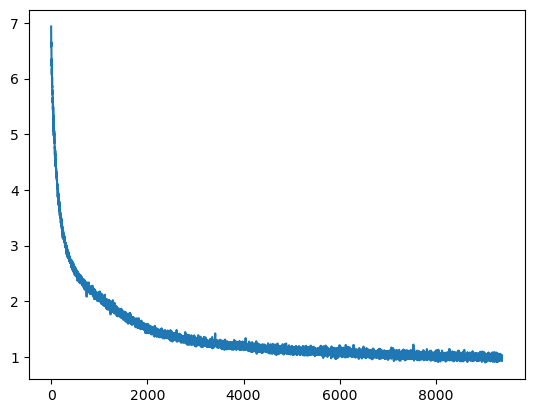

In [9]:
plt.plot(losses)

## Test

In [10]:
evaluate_ae(encoder, decoder, smiles, 1000, params=params)

mean token matching: 0.3771750330924988

['C1C2CCOC1C1[NH+]=CNCCC21', '[NH3+]C1CCC2C3CCC2(CCO3)C1', 'OC1C2CCC3C1C1CCCC23[NH2+]1', 'C1OC2OC3CC2C1C1=C3OC=N1', 'ClC1=C2CCOC2=NC2=C1N=CS2', 'C1[NH2+]C2C3CC11OC(C3)CCNC21', 'OC12CCC3CCC1C(=O)NC3C2', '[NH3+]C1CCN2C3CC4OCC3CC124', '[CH-]1C2=CON=C2C2=C1C=NS2', 'C1CC2=C(C1)C1=C(NC=N1)O2']
['OHH]1=C1=4C[[[4[HHH]21=NH)]C2', '', ']]22', '', 'H]]', 'H+]2=C=4+]', '', 'CHH]1=C=CCCCCCCCCCCCCCCCCCCCC[[[[[HH', '', '']
